# Deep Convolutional GAN (DCGAN)

### Goal
Use convolution layers instead of fully connected layers in previous assignment. The GAN that uses convolutions layers is also called DCGAN.
Se paper [here](https://arxiv.org/pdf/1511.06434v1.pdf)!

#### DCGAN
Recall few things about DC GAN, We will guide you in whole proccess!

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->

We have seen CNN in class, and we recall these now. See lecture slides if you forgot these!

*   We use convolutions but no pooling layers
*   We use batchnorm for both the generator and the discriminator block
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

Go through the code below and answer these questions to test your understanding of code. Write your answers below this by creating a text cell.

1. **Purpose of `show_tensor_images` Function:**
   - What is the main purpose of the `show_tensor_images` function in the context of training a DCGAN model?
     - A) To adjust the learning rate of the model during training.
     - B) **To display a grid of generated images for visual assessment of the model's performance.**
     - C) To convert image tensors to grayscale images.
     - D) To calculate the loss function of the generator or discriminator.

2. **Image Tensor Normalization:**
   - The `show_tensor_images` function normalizes image tensors before displaying them. What is the range of values for the image tensor after normalization?
     - A) 0 to 1
     - B) **-1 to 1**
     - C) 0 to 255
     - D) -255 to 255

3. **Visualization Grid Configuration:**
   - How does the `show_tensor_images` function arrange the images when displaying them?
     - A) In a single row, placing all images side by side.
     - B) In a single column, stacking all images vertically.
     - C) **In a grid with a fixed number of rows and columns determined by the `num_images` parameter.**
     - D) In a grid with 5 images per row, adjusting the number of rows based on the `num_images` parameter.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." -->
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

Questions (Make answers by making that option bold by putting ** before and after the sentence! ):


1. **What is the purpose of the `z_dim` parameter in the `Generator` class?**
    - A. It defines the number of channels in the generated images.
    - B. It controls the learning rate of the generator.
    - C. **It specifies the dimension of the noise vector used as input.**
    - D. It determines the size of the final convolutional filters.

2. **What is the main function of the `make_gen_block` function?**
    - A. It calculates the loss function for the generator.
    - B. **It defines a sequence of operations for a single block in the generator network.**
    - C. It converts a noise vector into an image representation.
    - D. It applies batch normalization to the entire generated image.

3. **What is the difference between the activation function used in the hidden layers and the final layer of the generator?**
    - A. There is no difference, ReLU is used throughout.
    - B. Leaky ReLU is used in hidden layers and ReLU in the final layer.
    - C. **ReLU is used in hidden layers and Tanh is used in the final layer.**
    - D. Sigmoid is used in hidden layers and Softmax in the final layer.

4. **What does the `unsqueeze_noise` function do?**
    - A. It adds random noise to the generated images.
    - B. It reduces the dimensionality of the noise vector.
    - C. **It expands the noise vector to include width, height, and channel information.**
    - D. It converts the noise vector from a CPU tensor to a GPU tensor.

5. **What is the role of the `get_noise` function?**
    - A. It measures the quality of the generated images.
    - B. It updates the weights of the generator network during training.
    - C. **It creates a tensor filled with random noise for input to the generator.**
    - D. It saves the generated images to a specific file format.

## Question: Complete the code

Fill the section mentioned with "start code here"  and "End code here"



In [2]:

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:

'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Here's the test for your generator block:

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.
<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

## Question:
Draw architecture diagram of Discriminator and attack the pic here.

<img src='./plots/dcgan-disc.png'>


## Quiz on the Discriminator Class (Make your answer bold):

1. **What is the primary function of the Discriminator in a DCGAN?**
     - A. It generates new images based on a noise vector.
     - B. **It classifies an input image as real or fake (generated).**
     - C. It calculates the loss function for both the generator and discriminator.
     - D. It preprocesses the images before feeding them to the generator.

2. **What is the key difference between the activation function used in the Discriminator's hidden layers and the final layer?**
     - A. There is no difference, LeakyReLU is used throughout.
     - B. ReLU is used in hidden layers and LeakyReLU in the final layer.
     - C. **LeakyReLU with a slope of 0.2 is used in hidden layers, and no activation is used in the final layer.**
     - D. Sigmoid is used in hidden layers and Tanh in the final layer.

3. **What does the `make_disc_block` function accomplish?**
     - A. It adds noise to the image to make it appear more realistic.
     - B. It expands the dimensionality of the image feature representation.
     - C. **It defines a sequence of operations for a single block in the discriminator network.**
     - D. It converts the image tensor from a format suitable for the generator.

4. **What is the role of the `nn.BatchNorm2d` layer in the discriminator blocks (except the final layer)?**
     - A. It increases the non-linearity of the network.
     - B. It introduces randomness to prevent overfitting.
     - C. **It normalizes the activations across channels, improving training stability.**
     - D. It reduces the number of parameters in the network.

5. **What does the final line of the `forward` function achieve?**
     - A. It adds a bias term to the output of the discriminator.
     - B. It converts the image data type from float to integer.
     - C. **It reshapes the output tensor from a multi-dimensional tensor to a 1-dimensional vector.**
     - D. It applies a final activation function (e.g., sigmoid) to get a probability score.

## Complete the code

Fill the region between "Start your code here" and "End your code here"

In [5]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:

'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Here's a test for your discriminator block:

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Here are the training parameters:

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [10]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 5000
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for now!
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Initialize: generator, discriminator, and optimizers.

In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

**Moment of Truth**
If everything went well above, then you are all set to generate cool looking handwritten digits!

You may additionally try with other datasets such as Fashion MNIST.
Will your code work as it is if you use another dataset? What do you need to change? Both MNIST and FashioMNIST are grescale images, what if you use color image datasets such as CIFAR10, what do you need to change in your code?

> Ans: The code will work for other dataset too except we need to change the dataloader. To use color images, we need to pass ```input_channels = 3```.

It takes around 30 seconds on GPU on colab and around 8 hours on CPU. May the luck be with you on Colab!

The figures should get printed after every 5000 steps, why? Can you see the code and understand why?
> Ans: Yes, the code is present at the last of the training loop.

After the figure is printed around 5K step, did you notice any mode collapse?
Recall mode collapse from lecture slides in case you forgot!

> Ans: The results so far doesnot show much occurence of mode collapse. This can be verified from the discriminator and generator losses. Mode collapse refers to a situation where the discriminator is able to discriminate between the fake and generated images with high probability, which means the discriminator loss would be extremely less. But in our case, the discriminator loss remains relatively high, suggesting no mode collapse. 

Without giving too much explaination, we expect that you learn the code by yourself, and answer the following question. You may add a text cell to put your answer in this notebook itself!


Based on the provided code below, answer the following questions:

1. **Understanding the Training Loop Structure:**
   - What is the purpose of the outer loop (`for epoch in range(n_epochs)`) in the provided code?
     - A) **To iterate over the dataset multiple times.**
     - B) To update the generator's parameters only.
     - C) To update the discriminator's parameters only.
     - D) To calculate the final loss of the model.

2. **Discriminator Loss Calculation:**
   - How is the discriminator's loss calculated in the provided code?
     - A) **By averaging the losses obtained from real and fake data.**
     - B) By subtracting the loss of fake data from the real data.
     - C) By adding the losses obtained from real and fake data without averaging.
     - D) By using the loss of fake data only.

3. **Generator Update Process:**
   - What steps are involved in updating the generator's parameters?
     - A) Calculate discriminator loss, then generator loss, and finally update the generator.
     - B) **Zero the generator's gradients, calculate generator loss, perform backpropagation, and update the generator's optimizer.**
     - C) Zero the discriminator's gradients, calculate generator loss, and update the discriminator's optimizer.
     - D) Update the generator's optimizer without calculating the generator loss.

4. **Function of `gen_opt.zero_grad()` and `disc_opt.zero_grad()`:**
   - What is the purpose of calling `gen_opt.zero_grad()` and `disc_opt.zero_grad()` before computing the respective losses?
     - A) To ensure the gradients are accumulated over epochs.
     - B) **To reset the gradients before each optimization step.**
     - C) To double the gradients for more effective learning.
     - D) To initialize the optimizer's learning rate.

5. **Visualization and Loss Reporting:**
   - Under what condition will the code print the generator and discriminator losses, and display the images?
     - A) After each batch is processed.
     - B) After each epoch is completed.
     - C) **When `cur_step` is a multiple of `display_step` and `cur_step` is greater than 0.**
     - D) Only at the end of all epochs.


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.3381206528961662, discriminator loss: 0.47589223540388076


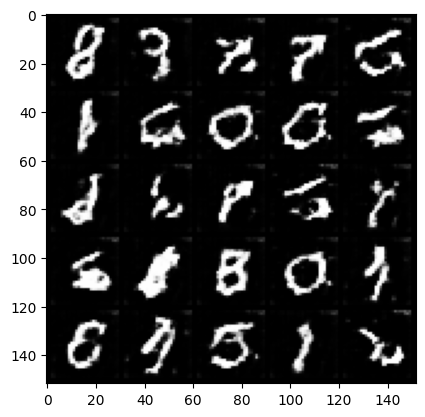

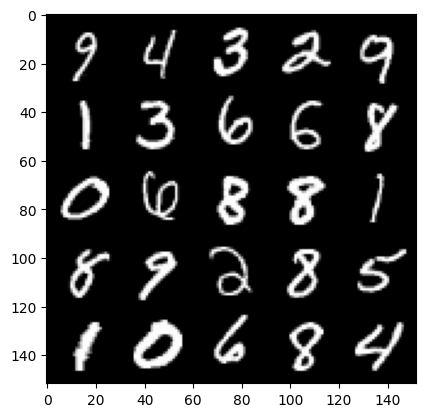

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.774048556864263, discriminator loss: 0.6729915159344678


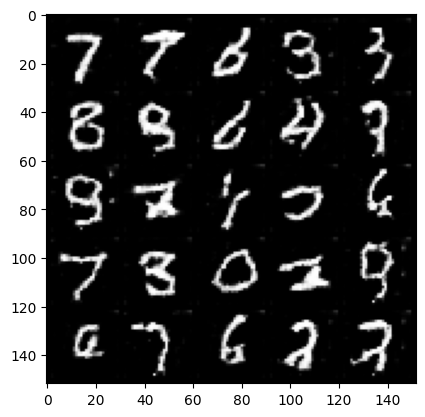

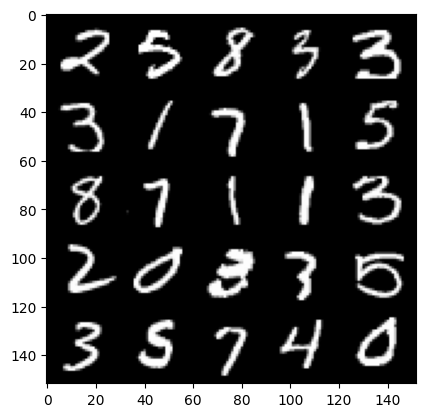

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7198453735649571, discriminator loss: 0.6969215583801256


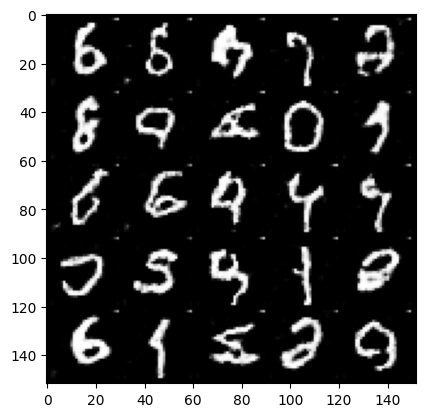

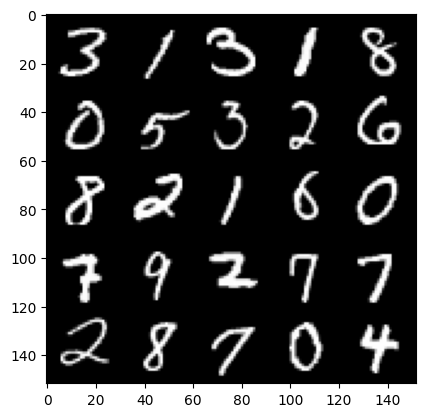

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7044112051069737, discriminator loss: 0.6977978767395041


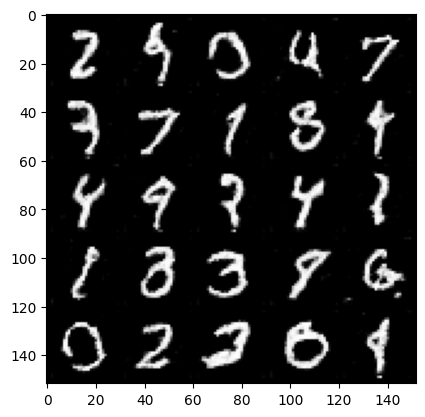

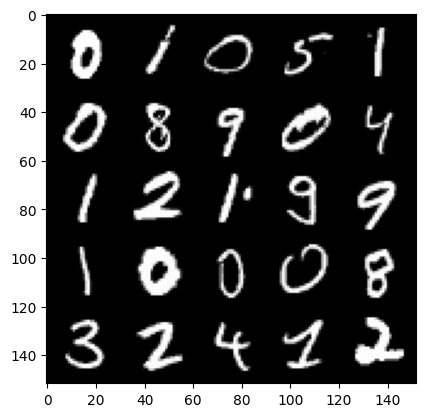

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [12]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
